## Exploring Non-Linear Clustering of Health and Behavioral Patterns Using DBSCAN


### Introduction
Clustering methods allow us to identify hidden patterns in data by grouping similar observations. 
While K-Means is one of the most commonly used clustering algorithms, it assumes that clusters are convex and similar in size — 
an assumption that doesn’t always hold in real-world health data. In this project, 
I employed DBSCAN (Density-Based Spatial Clustering of Applications with Noise) 
to uncover natural groupings within the NHANES dataset that may be missed by linear approaches.



### Step 1: Setup & Load Data

We begin by importing the necessary libraries and loading the cleaned NHANES dataset.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.impute import SimpleImputer

np.set_printoptions(precision=3)


### Step 2: Load and Prepare the Dataset

We convert time-like string variables into numerical minutes, drop missing data, and scale all features.

In [ ]:
# Load dataset
####### MAKE SURE TO ADJUST TO THE CORRECT PATH FOR YOURSELF ############
df = pd.read_csv("/Users/brandonfox/Downloads/merged_clean.csv")

# Convert time columns (in HH:MM format) to total minutes
def time_to_minutes(t):
    try:
        h, m = map(int, t.split(":"))
        return h * 60 + m
    except:
        return np.nan

# Apply time conversion to relevant columns
for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains(':', na=False).any():
        df[col] = df[col].apply(time_to_minutes)

# Drop columns that are mostly missing (over 50%)
df_clean = df.dropna(axis=1, thresh=len(df) * 0.5)

# Drop rows with remaining missing values
df_clean = df_clean.dropna()

# Drop non-feature identifier columns
if "SEQN" in df_clean.columns:
    df_clean = df_clean.drop(columns=["SEQN"])





In [10]:
df.head()

,DMDEDUC2,HUQ030,DPQ090,FNQ470,DPQ010,SLQ310,FNQ510,DPQ080,FNQ540,DPQ060,...,HUQ090,FNQ530,INDFMPIR,DPQ030,FNQ520,DPQ040,DPQ050,SEQN,RIDSTATR,DMDHHSIZ
0,4.0,1.0,NaN,1.0,NaN,450.0,4.0,NaN,1.0,1.0,...,2.0,4.0,1.33,NaN,1.0,NaN,NaN,130386.0,2.0,3.0
1,5.0,1.0,NaN,2.0,NaN,420.0,2.0,NaN,NaN,NaN,...,2.0,5.0,1.32,NaN,1.0,NaN,NaN,130387.0,2.0,1.0
2,4.0,1.0,NaN,1.0,NaN,390.0,2.0,NaN,3.0,NaN,...,2.0,4.0,0.81,NaN,3.0,NaN,NaN,130388.0,2.0,5.0
3,5.0,1.0,NaN,1.0,NaN,420.0,3.0,NaN,1.0,NaN,...,2.0,4.0,5.00,NaN,1.0,NaN,NaN,130389.0,2.0,2.0
4,3.0,1.0,NaN,1.0,NaN,360.0,3.0,NaN,1.0,NaN,...,2.0,3.0,2.16,NaN,3.0,NaN,NaN,130390.0,2.0,5.0


In [11]:

df_clean.head()

,DMDEDUC2,HUQ030,FNQ470,SLQ310,FNQ510,FNQ540,SLQ300,HUQ042,RIAGENDR,SLQ330,RIDAGEYR,FNQ460,HUQ055,SLQ320,HUQ090,FNQ530,INDFMPIR,FNQ520,RIDSTATR,DMDHHSIZ
0,4.0,1.0,1.0,450.0,4.0,1.0,0.0,1.0,1.0,480.0,34.0,1.0,2.0,0.0,2.0,4.0,1.33,1.0,2.0,3.0
2,4.0,1.0,1.0,390.0,2.0,3.0,1260.0,1.0,2.0,540.0,27.0,1.0,2.0,1380.0,2.0,4.0,0.81,3.0,2.0,5.0
3,5.0,1.0,1.0,420.0,3.0,1.0,1380.0,1.0,1.0,480.0,59.0,1.0,1.0,0.0,2.0,4.0,5.00,1.0,2.0,2.0
4,3.0,1.0,1.0,360.0,3.0,1.0,1320.0,2.0,2.0,480.0,31.0,1.0,2.0,0.0,2.0,3.0,2.16,3.0,2.0,5.0
5,3.0,1.0,1.0,630.0,1.0,2.0,180.0,1.0,2.0,630.0,33.0,3.0,2.0,180.0,2.0,1.0,0.93,2.0,2.0,3.0


### Step 3: Scale Features and Reduce Dimensions for Visualization

We standardized all numeric features to ensure each contributes equally to the analysis. Then, we applied Principal Component Analysis (PCA) to reduce the high-dimensional data to two principal components for easier visualization.

In [12]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean)


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


### Step 4: Run DBSCAN Clustering

DBSCAN is a density-based clustering method that groups together points close to each other and marks isolated points as noise. This approach is especially useful for discovering clusters of varying shapes and sizes.

In [13]:
dbscan = DBSCAN(eps=2.0, min_samples=5)
labels = dbscan.fit_predict(X_scaled)

### Step 5: Define Visualization Function

To clearly visualize the clusters, we created a custom plotting function that displays the data points in the PCA-reduced space, colored by their assigned cluster labels with a legend for easy interpretation.

In [14]:
# Custom cluster plotter
def plot_labelled_scatter(X, y, labels):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(y)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        plt.scatter(
            X[y == label, 0],
            X[y == label, 1],
            c=[color],
            label=labels[label] if label < len(labels) else f"Cluster {label}",
            s=25,
            alpha=0.7
        )

    plt.legend()
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(alpha=0.2)
    plt.tight_layout()


### Step 6: Plot Results

We adjusted the cluster labels so that noise points labeled as -1 become 0, then plotted the PCA-transformed data with color-coded clusters to visually interpret the DBSCAN results.

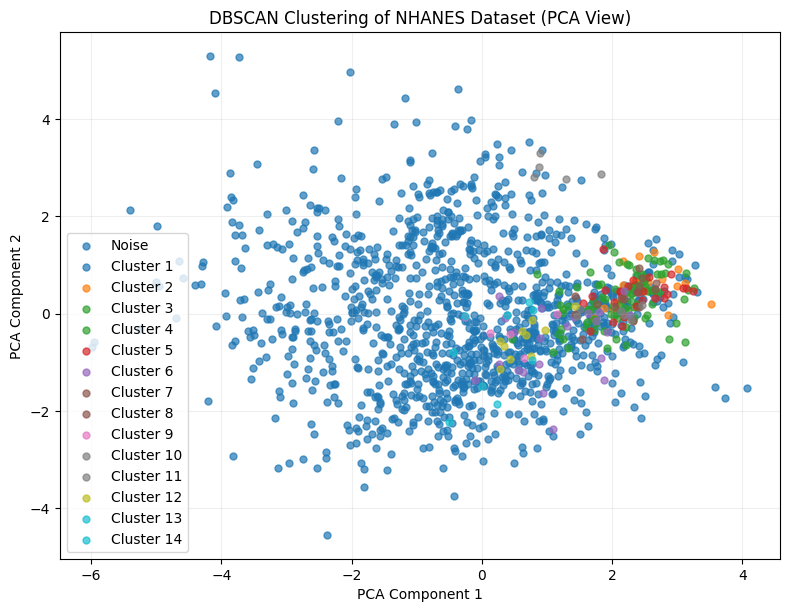

DBSCAN found 14 clusters and 1130 noise points.


In [18]:
# Adjust labels for plotting
cluster_labels = labels + 1  # So noise becomes label 0
label_names = ["Noise"] + [f"Cluster {i}" for i in range(1, np.max(cluster_labels) + 1)]

# Plot PCA-based cluster view
plot_labelled_scatter(X_pca, cluster_labels, label_names)
plt.title("DBSCAN Clustering of NHANES Dataset (PCA View)")
plt.show()

# Cluster summary
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)
print(f"DBSCAN found {n_clusters} clusters and {n_noise} noise points.")


Without noise

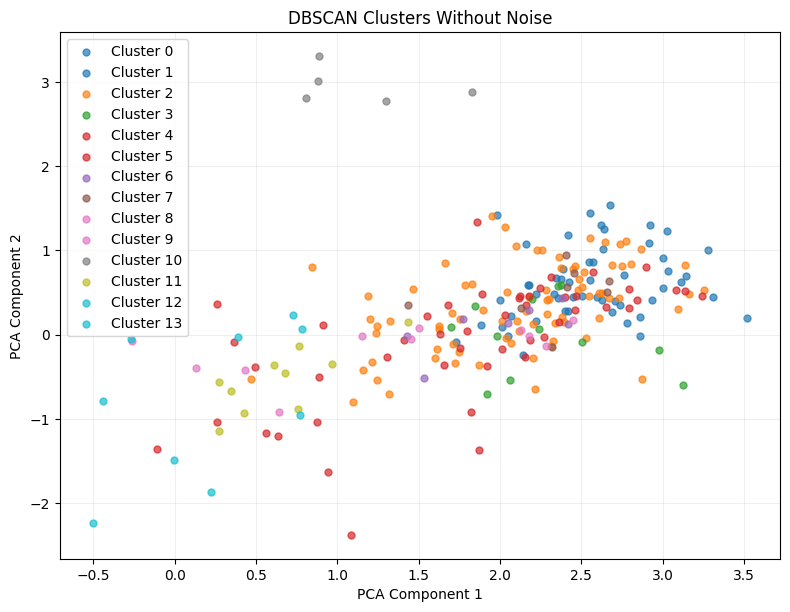

In [19]:
# Filter out noise points
mask = labels != -1
X_pca_clusters = X_pca[mask]
labels_clusters = labels[mask]

# Adjust labels so they start from 0 for plotting (optional)
unique_labels = np.unique(labels_clusters)
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels_clusters])

# Plot clusters without noise
plot_labelled_scatter(X_pca_clusters, mapped_labels, 
                      [f"Cluster {i}" for i in range(len(unique_labels))])
plt.title("DBSCAN Clusters Without Noise")
plt.show()


### Step 7: Rank Feature Importance

I added cluster labels to the cleaned dataset, excluded noise points, then calculated the average of each feature within clusters. Finally, I ranked features by the range of their average values across clusters to identify those most important for separating the groups.



In [16]:
# Add cluster labels to the DataFrame (we don't include noise for ranking)
df_labeled = df_clean.copy()
df_labeled["Cluster"] = labels

# Filter out noise points (-1) for importance ranking
df_clusters_only = df_labeled[df_labeled["Cluster"] != -1]

# Calculate mean of each feature per cluster
cluster_means = df_clusters_only.groupby("Cluster").mean(numeric_only=True)

# Compute range of each feature's mean across clusters
feature_ranges = cluster_means.max() - cluster_means.min()

# Sort features by descending importance
important_features = feature_ranges.sort_values(ascending=False)

# Display top N
top_n = 15
print("Top 15 Most Important Features by Mean Range Across DBSCAN Clusters:")
print(important_features.head(top_n))


Top 15 Most Important Features by Mean Range Across DBSCAN Clusters:
SLQ300      1320.000000
SLQ320      1308.000000
SLQ330       107.500000
SLQ310       102.000000
RIDAGEYR      37.916667
DMDHHSIZ       4.022222
INDFMPIR       3.652500
FNQ540         2.000000
FNQ520         2.000000
FNQ510         1.866667
DMDEDUC2       1.500000
RIAGENDR       1.000000
FNQ460         1.000000
HUQ055         1.000000
HUQ090         1.000000
dtype: float64


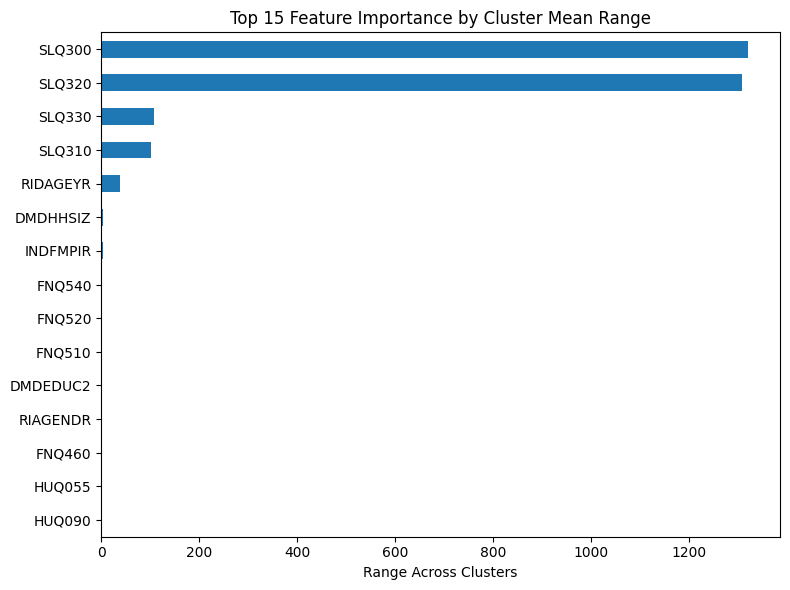

In [ ]:
# Bar plot of top important features
important_features.head(top_n).plot(kind='barh', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importance by Cluster Mean Range")
plt.xlabel("Range Across Clusters")
plt.tight_layout()
plt.show()


### Step 8: Handling Missing Values Before Clustering

Since DBSCAN cannot process missing values directly, it’s important to handle NaNs in the dataset before clustering. Different strategies for dealing with missing data can significantly impact the clustering results. Common approaches include dropping rows or columns with missing values or imputing them using methods such as mean, median, or K-Nearest Neighbors (KNN) imputation. Imputation helps preserve data structure by filling in missing entries with estimated values, allowing DBSCAN to work on a complete dataset. Exploring different missing data treatments and comparing their effects on the clusters provides insight into how data preprocessing choices influence the final patterns detected.

In [32]:
df = pd.read_csv("/Users/brandonfox/Downloads/merged_clean.csv")

def time_to_minutes(t):
    try:
        h, m = map(int, t.split(":"))
        return h * 60 + m
    except:
        return np.nan

for col in df.columns:
    if df[col].dtype == 'object' and df[col].str.contains(':', na=False).any():
        df[col] = df[col].apply(time_to_minutes)

df_partial = df.dropna(axis=1, thresh=len(df) * 0.5)

if "SEQN" in df_partial.columns:
    df_partial = df_partial.drop(columns=["SEQN"])

imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_partial), columns=df_partial.columns)

scaler = StandardScaler()
X_scaled_imputed = scaler.fit_transform(df_imputed)

In [33]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_imputed)

/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/brandonfox/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


In [34]:
dbscan = DBSCAN(eps=2.0, min_samples=5)
labels_imputed = dbscan.fit_predict(X_scaled_imputed)

In [35]:
def plot_labelled_scatter(X, y, labels):
    plt.figure(figsize=(8, 6))
    unique_labels = np.unique(y)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        plt.scatter(
            X[y == label, 0],
            X[y == label, 1],
            c=[color],
            label=labels[label] if label < len(labels) else f"Cluster {label}",
            s=25,
            alpha=0.7
        )

    plt.legend()
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.grid(alpha=0.2)
    plt.tight_layout()

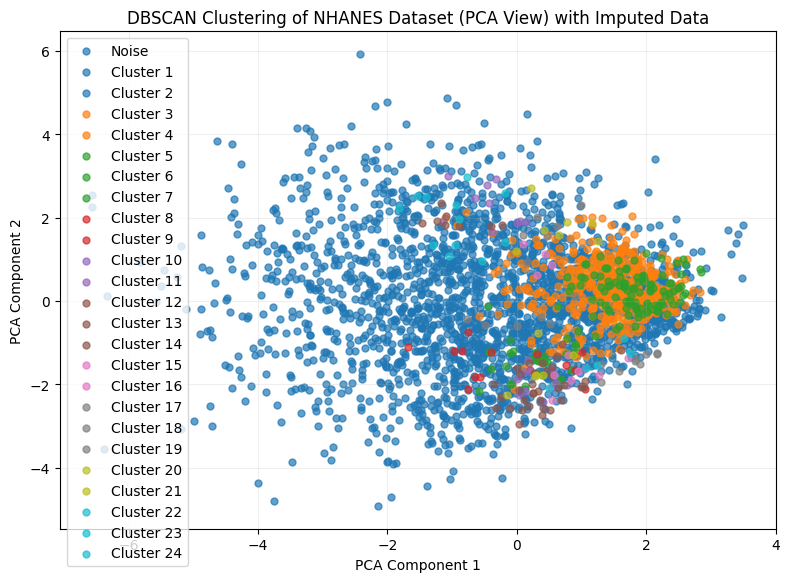

In [36]:
cluster_labels = labels_imputed + 1  # So noise becomes label 0
label_names = ["Noise"] + [f"Cluster {i}" for i in range(1, np.max(cluster_labels) + 1)]

plot_labelled_scatter(X_pca, cluster_labels, label_names)
plt.title("DBSCAN Clustering of NHANES Dataset (PCA View) with Imputed Data")
plt.show()


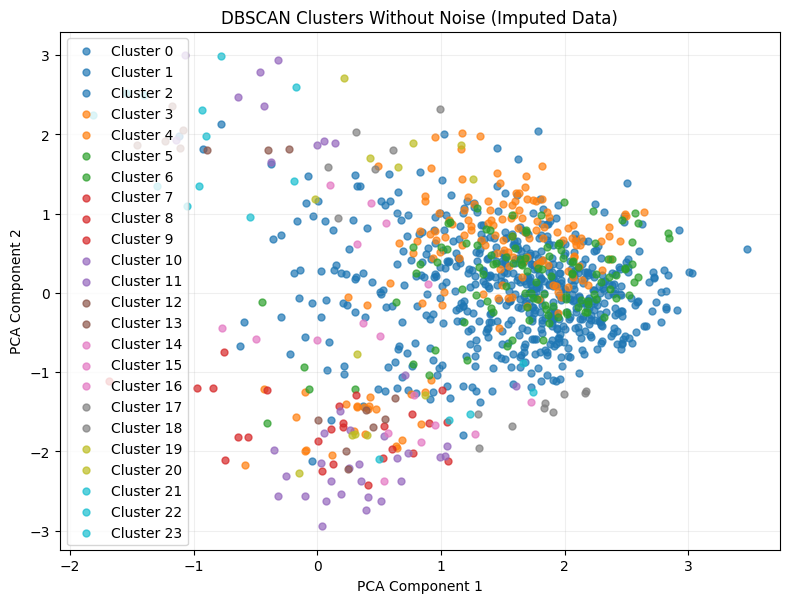

In [37]:
mask = labels_imputed != -1
X_pca_clusters = X_pca[mask]
labels_clusters = labels_imputed[mask]

unique_labels = np.unique(labels_clusters)
label_mapping = {old_label: new_label for new_label, old_label in enumerate(unique_labels)}
mapped_labels = np.array([label_mapping[label] for label in labels_clusters])

plot_labelled_scatter(X_pca_clusters, mapped_labels, 
                      [f"Cluster {i}" for i in range(len(unique_labels))])
plt.title("DBSCAN Clusters Without Noise (Imputed Data)")
plt.show()



In [38]:
# Add cluster labels to the imputed DataFrame (excluding noise)
df_labeled_imputed = df_imputed.copy()
df_labeled_imputed["Cluster"] = labels_imputed

# Filter out noise points (-1)
df_clusters_only_imputed = df_labeled_imputed[df_labeled_imputed["Cluster"] != -1]

# Calculate mean of each feature per cluster
cluster_means_imputed = df_clusters_only_imputed.groupby("Cluster").mean(numeric_only=True)

# Compute range of each feature's mean across clusters
feature_ranges_imputed = cluster_means_imputed.max() - cluster_means_imputed.min()

# Sort features by descending importance
important_features_imputed = feature_ranges_imputed.sort_values(ascending=False)

# Display top 15 features
top_n = 15
print("Top 15 Most Important Features by Mean Range Across DBSCAN Clusters (Imputed Data):")
print(important_features_imputed.head(top_n))


Top 15 Most Important Features by Mean Range Across DBSCAN Clusters (Imputed Data):
SLQ300      1361.000000
SLQ320      1356.666667
SLQ310       166.571429
SLQ330       166.428571
RIDAGEYR      41.041667
FNQ510         3.833333
DMDHHSIZ       3.722222
FNQ530         3.666667
INDFMPIR       3.185000
DMDEDUC2       2.166667
FNQ540         2.000000
FNQ520         2.000000
RIAGENDR       1.000000
HUQ030         1.000000
FNQ460         1.000000
dtype: float64


## Comparison of DBSCAN Cluster Feature Importance: Dropna vs. Median Imputation

To explore how missing data handling methods impact DBSCAN clustering results, we compared two approaches applied to the NHANES dataset:

- **Original Approach:** Rows with any missing values were dropped after removing columns with >50% missing data.
- **Imputed Approach:** The same columns were retained (dropped if >50% missing), but missing values in the remaining data were **imputed using the median** instead of dropping entire rows.

We then applied standard scaling, dimensionality reduction (PCA), and DBSCAN clustering to both versions of the dataset. For feature importance, we measured the **range of each feature’s mean across clusters (excluding noise)** — larger ranges indicate greater discriminative power across cluster boundaries.

---

### Top 15 Features (Dropna vs. Median Imputed)

| Rank | Feature   | Dropna Range | Imputed Range | Notes                              |
|------|-----------|--------------|----------------|------------------------------------|
| 1    | SLQ300    | **1320.00**  | **1361.00**     | Consistently dominant              |
| 2    | SLQ320    | **1308.00**  | **1356.67**     | Strong agreement                   |
| 3    | SLQ330    | **107.50**   | **166.43**      | Large increase in variation        |
| 4    | SLQ310    | **102.00**   | **166.57**      | Same as above                      |
| 5    | RIDAGEYR  | **37.92**    | **41.04**       | Minor increase                     |
| 6    | DMDHHSIZ  | **4.02**     | **3.72**        | Similar impact                     |
| 7    | INDFMPIR  | **3.65**     | **3.19**        | Slight drop in range               |
| 8    | FNQ540    | **2.00**     | **2.00**        | Stable across imputations          |
| 9    | FNQ520    | **2.00**     | **2.00**        | Stable across imputations          |
| 10   | FNQ510    | **1.87**     | **3.83**        | Greater variation post-imputation  |
| 11   | DMDEDUC2  | **1.50**     | **2.17**        | More spread post-imputation        |
| 12   | RIAGENDR  | **1.00**     | **1.00**        | No change                          |
| 13   | FNQ460    | **1.00**     | **1.00**        | No change                          |
| 14   | HUQ055    | **1.00**     | —               | Not in top 15 after imputation     |
| 15   | HUQ090    | **1.00**     | —               | Not in top 15 after imputation     |
| —    | FNQ530    | —            | **3.67**        | *Newly surfaced with imputation*   |
| —    | HUQ030    | —            | **1.00**        | *Also new with imputation*         |

---

| Rank | Feature                                                     | Dropna Range | Imputed Range | Notes                              |
|------|-------------------------------------------------------------|--------------|----------------|------------------------------------|
| 1    | Usual sleep time on weekdays or workdays                   | **1320.00**  | **1361.00**     | Consistently dominant              |
| 2    | Usual sleep time on weekends                               | **1308.00**  | **1356.67**     | Strong agreement                   |
| 3    | Usual wake time on weekends                                | **107.50**   | **166.43**      | Large increase in variation        |
| 4    | Usual wake time on weekdays or workdays                    | **102.00**   | **166.57**      | Same as above                      |
| 5    | Age in years at screening                                  | **37.92**    | **41.04**       | Minor increase                     |
| 6    | Total number of people in the Household                    | **4.02**     | **3.72**        | Similar impact                     |
| 7    | Ratio of family income to poverty                          | **3.65**     | **3.19**        | Slight drop in range               |
| 8    | Level of feeling depressed                                 | **2.00**     | **2.00**        | Stable across imputations          |
| 9    | Level of feeling worried/nervous/anxious                   | **2.00**     | **2.00**        | Stable across imputations          |
| 10   | How often feel worried/nervous/anxious                     | **1.87**     | **3.83**        | Greater variation post-imputation  |
| 11   | Education level - Adults 20+                               | **1.50**     | **2.17**        | More spread post-imputation        |
| 12   | Gender                                                     | **1.00**     | **1.00**        | No change                          |
| 13   | Difficulty remembering or concentrating                    | **1.00**     | **1.00**        | No change                          |
| 14   | Past 12 months had video conf w/Dr?                        | **1.00**     | —               | Not in top 15 after imputation     |
| 15   | Seen mental health professional/past yr                    | **1.00**     | —               | Not in top 15 after imputation     |
| —    | How often feel depressed                                   | —            | **3.67**        | *Newly surfaced with imputation*   |
| —    | Routine place to go for healthcare                         | —            | **1.00**        | *Also new with imputation*         |

---

### Interpretation & Implications

- **Consistency at the Top:** `SLQ300` and `SLQ320` were dominant in both runs, with slightly higher range values in the imputed dataset — a strong sign of their consistent importance in segmenting the population.
  
- **Greater Feature Variation with Imputation:** Features like `SLQ330`, `SLQ310`, and `FNQ510` saw **substantial increases** in their range across clusters after median imputation. This suggests that imputing missing values allowed these features to better reflect underlying cluster separation, potentially recovering structure lost by dropping rows.

- **Emerging Features:** Some features (e.g., `FNQ530`, `HUQ030`) **only appeared** in the top 15 when using imputation, likely because they were previously excluded or had insufficient non-null values to exert meaningful influence.

- **Stable Predictors:** A few features (e.g., `FNQ540`, `FNQ520`, `RIAGENDR`) remained unchanged, indicating robustness to the missing value strategy.

---

### Conclusion

Median imputation not only retained more data but also enhanced the clustering performance of certain variables by increasing their variability across groups. While the top features remained mostly consistent, the imputed model surfaced **stronger signal** in mid-tier features and introduced **new variables** into the importance ranks. For tasks involving unsupervised learning with moderate missingness, median imputation offers a compelling advantage over strict row-dropping.


In [40]:
column_mapping = {
    'DMDHHSIZ': 'Total number of people in the Household',
    'DMDEDUC2': 'Education level - Adults 20+',
    'DPQ010': 'Have little interest in doing things',
    'DPQ020': 'Feeling down, depressed, or hopeless',
    'DPQ030': 'Trouble sleeping or sleeping too much',
    'DPQ040': 'Feeling tired or having little energy',
    'DPQ050': 'Poor appetite or overeating',
    'DPQ060': ' Feeling bad about yourself',
    'DPQ070': 'Trouble concentrating on things',
    'DPQ080': 'Moving or speaking slowly or too fast',
    'DPQ090': 'Thought you would be better off dead',
    'DPQ100': 'Difficulty these problems have caused',
    'FNQ460': 'Difficulty remembering or concentrating',
    'FNQ470': 'Difficulty with self-care',
    'FNQ510': 'How often feel worried/nervous/anxious',
    'FNQ520': 'Level of feeling worried/nervous/anxious',
    'FNQ530': 'How often feel depressed',
    'FNQ540': 'Level of feeling depressed',
    'HUQ030': 'Routine place to go for healthcare',
    'HUQ042': 'Type place most often go for healthcare',
    'HUQ055': 'Past 12 months had video conf w/Dr?',
    'HUQ090': 'Seen mental health professional/past yr',
    'INDFMPIR': 'Ratio of family income to poverty',
    'PHQ9_SEVERITY': 'PHQ-9 Severity Level',
    'PHQ9_TOTAL': 'PHQ-9 Total Score',
    'RIAGENDR': 'Gender',
    'RIDAGEYR': 'Age in years at screening',
    'RIDSTATR': 'Interview/Examination status',
    'SEQN': 'Respondent sequence number',
    'SLQ300': 'Usual sleep time on weekdays or workdays',
    'SLQ310': 'Usual wake time on weekdays or workdays',
    'SLQ320': 'Usual sleep time on weekends',
    'SLQ330': 'Usual wake time on weekends'
}